TP1 - Recalage d'images
=============

Groupe : NGUYEN Minh Hai et LE Cam Thanh Ha

4 GMM A

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g

In [3]:
f,g=get_images()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(21, 21) (21, 21)


Text(0.5, 1.0, 'Image objective g')

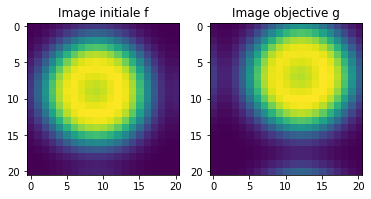

In [4]:
print(type(f))
print(type(g))
print(np.shape(f), np.shape(g))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(f)
ax2.imshow(g)
ax1.set_title("Image initiale f")
ax2.set_title("Image objective g")

$f,g$ sont des images de taille $21 \times 21$

# 1. Formalisation du problème

1.1 Formalisme continu
---------------------

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème inverse $(P_1)$ : 

> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations \ de \ volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

### Question 1. A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$\langle \nabla E(u),h\rangle = \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

$\color{green}{\text{\large Reponse}}$

<span style="font-family:romain; color:green; font-size:16px"> En utilisant le developpement de Taylor, pour tout $h$ dans $H_1(\Omega)$:

$$\color{green}{\begin{align*} f(x + u(x) + h(x)) = f(x + u(x))  + \langle \nabla f(x + u(x)), h(x) \rangle + o(\lVert h(x) \rVert)  \end{align*}}$$

<span style="font-family:romain; color:green; font-size:16px"> Donc, pour tout $h$ dans $H_1(\Omega)$, on a egalement:

$$\begin{align*} E(u+h) &= \frac{1}{2}\int_\Omega \left( f(x+u(x) + h(x))-g(x) \right)^2 dx \\ &= \frac{1}{2}\int_\Omega \left( f(x + u(x))  + \langle \nabla f(x + u(x)), h(x) \rangle + o(\lVert h(x) \rVert)-g(x) \right)^2 dx
\\ &= \frac{1}{2}\int_\Omega \left( f(x+u(x))-g(x) \right)^2 dx + \int_\Omega \left( f(x + u(x)) - g(x) \right) \left( \langle \nabla f(x + u(x)), h(x) \rangle + o(\| h(x) \| \right) dx + \frac{1}{2} \underbrace{\int_\Omega \left(  \langle \nabla f(x + u(x)), h(x) \rangle + o(\| h(x) \| \right)^2 dx}_{o(\| h \|)}
\\ &=  E(u) + \int_\Omega \left( f(x + u(x)) - g(x) \right) \left( \langle \nabla f(x + u(x)), h(x) \rangle \right) dx + \underbrace{\int_\Omega \left( f(x + u(x)) - g(x) \right) o(\| h(x) \| dx}_{o(\| h \|)} + o(\| h \|)
\\ &=  E(u) + \int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx + o(\lVert h \rVert)\end{align*}
 $$

 <span style="font-family:romain; color:green; font-size:16px"> On en deduit que 
 $$\color{green}{\nabla E(u) =  \left( f(x + u(x)) - g(x) \right) \nabla f(x + u(x)) =\left(f\circ (id+u) -g\right)\nabla f\circ (id+u)}$$




# 2. Discrétisation

Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [5]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx, ny = f.shape
    ip = interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y] = np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X = X + ux
    Y = Y + uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

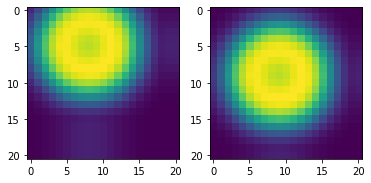

In [6]:
fig2, ax2 = plt.subplots(1,2)
ax2[0].imshow(interpol(f, np.ones(np.shape(f)) + 3, np.ones(np.shape(f))) + 3)
ax2[1].imshow(f)


In [7]:
[X,Y] = np.meshgrid(np.arange(5), np.arange(5), indexing="ij")
print(X)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


2.2. Calcul de $R$ et de son gradient
-------------------------------------
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$

### Question 2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.



$\color{green}{\text{\large Reponse}}$

<span style="font-family:romain; color:green; font-size:16px">On a la derivée partielle de $f$ par rapport à $x$ est

$$\color{green}{\begin{cases}(\partial_x f)_{i,j} &= f_{i,j+1}-f_{i,j} &\text{ si } j<n \\
(\partial_x f)_{i,j} &= 0 &\text{ si } j = n\end{cases}}$$

Par la symetrie, on a la derivée partielle de $f$ par rapport à $y$ est

$$\color{green}{\begin{cases}(\partial_y f)_{i,j} &= f_{i,j+1}-f_{i,j} &\text{ si } j<n \\
(\partial_y f)_{i,j} &= 0 &\text{ si } j = n\end{cases}}$$


On a :
$$\begin{align}
\langle \partial _x f, g \rangle &= \sum_{i=1}^{n}\sum_{j=1}^{n}(\partial_x f)_{i,j}g_{ij}\\
&= \sum_{i=1}^{n-1}\sum_{j=1}^{n}(f_{i+1,j}-f_{ij})g_{ij}\\
&=\sum_{i=1}^{n-1}\sum_{j=1}^{n}f_{i+1,j}g_{ij}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}f_{ij}g_{ij}\\
&=\sum_{i=2}^{n}\sum_{j=1}^{n}f_{i,j}g_{i-1,j}-\sum_{i=1}^{n-1}\sum_{j=1}^{n}f_{ij}g_{ij}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}f_{i,j}g_{i-1,j}-\sum_{i=2}^{n-1}\sum_{j=1}^{n}f_{ij}g_{ij} - \sum_{j=1}^{n} f_{1j}g_{1j} + \sum_{j=1}^{n} f_{nj}g_{n-1,j}\\
&=\sum_{i=2}^{n-1}\sum_{j=1}^{n}f_{i,j}(g_{i-1,j}-g_{ij}) + \sum_{j=1}^{n} (f_{nj}g_{n-1,j}-f_{1j}g_{1j})\\ \\ \\
\end{align}$$

Par identification, on obtient les formules de discrétisation de $\partial _x ^T$ et $ \partial _y ^T$ respectivement :

$$\partial _x ^T=\begin{cases}f_{i-1,j}-f_{ij} \text{ si } i\geq 2 \text{ et } i \leq n-1 \\
f_{n-1,j} \text{ si } i=n \\
-f_{1,j} \text{ si } i=1 \end{cases} $$

$$\partial _y ^T=\begin{cases}f_{i,j-1}-f_{ij} \text{ si } j\in[2;n-1] \\
f_{i,n-1} \text{ si } j=n \\
-f_{i,1} \text{ si } j=1 \end{cases} $$

In [8]:
A = np.random.rand(3,3)
print(A)
B = np.zeros((3,3))
print(A[1:,:])

[[0.60314009 0.76053379 0.00522412]
 [0.21582848 0.80943065 0.14549059]
 [0.18142741 0.985133   0.46084931]]
[[0.21582848 0.80943065 0.14549059]
 [0.18142741 0.985133   0.46084931]]


In [9]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=np.zeros(im.shape)
    # To be implemented
    d[:,:-1] = im[:,1:] - im[:,:-1]
    return d
def dyT(im) :
    d=np.zeros(im.shape)
    # To be implemented
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]
    return d  
def dxT(im) :
    d=np.zeros(im.shape)
    # To be implemented
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1,:]
    d[-1,:] = im[-2,:]
    return d

### Question 3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

* On a 
$$ \begin{align*} R(u) &= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i) \\
    &= \frac{\mu}{2} \lVert \partial_x u_y + \partial_y u_x \rVert^2 + \frac{\lambda+\mu}{2} \lVert \partial_x u_x + \partial_y u_y \rVert^2
     \\
    &= \frac{\mu}{2} \left \langle \begin{pmatrix} \partial_y & \partial_x \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix}, \begin{pmatrix} \partial_y & \partial_x \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} \right\rangle   + \frac{\mu + \lambda}{2} \left \langle \begin{pmatrix} \partial_x & \partial_y \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix}, \begin{pmatrix} \partial_y & \partial_x \end{pmatrix} \begin{pmatrix} u_x \\ u_y \end{pmatrix} \right\rangle \\
    &= \left \langle A_1u, A_1u \right \rangle + \frac{1}{2} \left \langle A_2 u, A_2u \right \rangle
    \end{align*}
$$
avec $A_1 = \sqrt{\mu} \begin{pmatrix} \partial_y & \partial_x \end{pmatrix}$, $A_2 = \sqrt{\mu + \lambda} \begin{pmatrix} \partial_x & \partial_y \end{pmatrix}$ et $u = \begin{pmatrix} u_x \\ u_x \end{pmatrix}$


Donc on a 
$$\begin{align*}
R(u) &= \frac{1}{2} \left \langle A_1u, A_1u \right \rangle + \frac{1}{2} \left \langle A_2 u, A_2u \right \rangle \\
    &= \frac{1}{2}  \langle A_1^T A_1 u, u \rangle + \frac{1}{2} \langle A_2^T A_2 u, u  \rangle \\ 
    &= \frac{1}{2} \left \langle (A_1^T A_1 + A_2^T A_2)u,u \right \rangle \\ 
    &= \frac{1}{2} \langle Au,u \rangle 
\end{align*}$$

avec 
$$A = A_1^T A_1 + A_2^T A_2 = \mu \begin{pmatrix} \partial_y^T \partial_y & \partial_y^T \partial_x \\ \\  \partial_x ^T \partial_y & \partial_x^T \partial_x \end{pmatrix} + (\mu + \lambda)\begin{pmatrix} \partial_x^T \partial_x & \partial_x^T \partial_y \\ \\  \partial_y ^T \partial_x & \partial_y^T \partial_y \end{pmatrix} $$

### Question 4. Donner l'expression du gradient de $R$.

D'apres la question precedente, nous avons 


2.3. Implémentation de la fonction objectif $E+R$
----------------------------------------------

In [10]:
def objective_function(f,g,ux,uy,lamb,mu) :
    # raise ValueError('to be implemented') 
    # fu = f(x + u)
    
    fu = interpol(f,ux,uy)
    E = 0.5*np.linalg.norm(fu - g)**2
    R = 0.5*mu*np.linalg.norm(dx(uy) + dy(ux))**2 + 0.5*(mu + lamb)*np.linalg.norm(dx(ux) + dy(uy))**2
    obj = E + R
    return obj, fu

# 3. Un algorithme de gradient

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

### Question 5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire par rebroussement proposé ci-dessous.

In [11]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj > obj_old and step > 1.e-15:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

In [12]:
def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   
        # Gradient of E at point u
        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        # raise ValueError('Compute gradEx and gradEy here')
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (mu+lamb)*(dxT(dx(ux)) + dxT(dy(uy)))
        gradRy = mu*(dxT(dy(ux)) + dxT(dx(uy))) + (mu+lamb)*(dyT(dx(ux)) + dyT(dy(uy)))    
        # raise ValueError('Compute gradRx and gradRy here')
        
        # Gradient of E+R at point u
        # raise ValueError('Compute gradx and grady here')
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 1000 == 0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list)

### Question 6. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

In [13]:
lamb=0.11
mu=0.011
nitermax=5000

step0 = 0.01
ux,uy,CF,step=RecalageDG(f,g,lamb,mu,nitermax,step0)

iteration : 1000  cost function : 0.3304636823267523 step : 2.56
iteration : 2000  cost function : 0.2987433745416952 step : 2.56


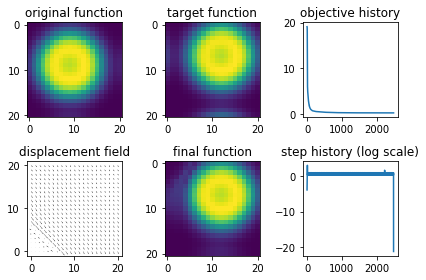

In [14]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

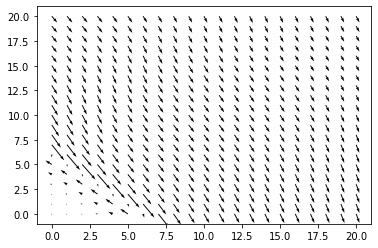

In [15]:
plt.quiver(ux, uy)
plt.show()

# 4. Algorithme de moindres carrés.

On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\text{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

### Question 6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

Notons 
$$\Psi(u)=\begin{pmatrix} 
\Psi_1(u) \\ 
\Psi_2(u) \\ 
\Psi_3(u) \end{pmatrix}$$
où $$\begin{cases}\Psi_1(u) = f\circ(id+u) -g \\
\Psi_2(u) = \sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\
\Psi_3(u) = \sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{cases} $$

### Question 7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [16]:
def JTPsi(phi,df,lamb,mu) :
    raise ValueError('to be implemented') 
    #return [ux,uy]
  
def JPsi(vx,vy,df,lamb,mu) :
    raise ValueError('to be implemented') 
    #return [JPsi0,JPsi1,JPsi2]
  
def JTJ(vx,vy,df,lamb,mu,epsilon) :
    raise ValueError('to be implemented') 
    #return uxs,uys

Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [17]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

### Question 8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [18]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)  
    raise ValueError('To complete if necessary')
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        raise ValueError('Compute b here')
        raise ValueError('Compute dfx,dfy here')    
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfx,dfy)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list)

### Question 9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [19]:
epsi=0.1
nitermax=1000
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,step0,epsi)

ValueError: To complete if necessary

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

In [ ]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

In [ ]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [ ]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)